## Incremental learning with River

In [122]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import sys
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from scipy.stats import mode
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.spatial.distance import mahalanobis
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [123]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [124]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [125]:
# feature selection (see previous part -- xgboost binary)
subset_indices =  [191, 374, 328, 673]

In [126]:
def plot_roc(true_y, y_prob, method_name):
    fpr, tpr, _ = roc_curve(true_y, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2 
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {method_name}')
    plt.legend(loc="lower right")
    plt.show()

### Recreate original dataset

In [127]:
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices_temp = np.array(random.sample(range(nbr_splits), test_split))
    test_indices = np.append(test_indices, i*nbr_splits + test_indices_temp)
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices_temp]))

print(len(train_indices))

544


In [128]:
train_ctr = 0
test_ctr = 0
data_all = []
labels_all = []
for i in range(612):
    if i in train_indices:
        data_all.append(X_train[train_ctr])
        labels_all.append(labels_train[train_ctr])
        train_ctr += 1
    elif i in test_indices:
        data_all.append(X_test[test_ctr])
        labels_all.append(labels_test[test_ctr])
        test_ctr += 1

In [129]:
y_all = binarize(labels_all) # is the labels of all instances 
data_all = np.array(data_all) # are all the instances

In [130]:
data_all_top = data_all[:, subset_indices] 
healthy_data = data_all_top[y_all == 0]
damage_data = data_all_top[y_all == 1]
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [131]:
# for occ labels are defined differently
damage_labels  = -1*np.ones(damage_data.shape[0])
healthy_labels =    np.ones(healthy_data.shape[0])

In [132]:
def fill_between_plot(x_range, average_obs, std_obs, label, title):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    for idx, (avg_obs, std_ob) in enumerate(zip(average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color = colors[idx], label=label)
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx], alpha=0.5, label='1 std dev')
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(label)
    plt.legend()
    plt.show()

In [133]:
def fill_between_plot_diffx(x_ranges, average_obs, std_obs, label, title, labely):
    plt.figure(figsize=(8, 5))
    colors = ['blue', 'cyan', 'red', 'green']
    
    # Ensure that x_ranges, average_obs, and std_obs have the same length
    if not (len(x_ranges) == len(average_obs) == len(std_obs)):
        raise ValueError("Length of x_ranges, average_obs, and std_obs must be the same")

    for idx, (x_range, avg_obs, std_ob) in enumerate(zip(x_ranges, average_obs, std_obs)):
        plt.plot(x_range, avg_obs, color=colors[idx % len(colors)], label=f'{label[idx]}')
        plt.fill_between(x_range, avg_obs - std_ob, avg_obs + std_ob, color=colors[idx % len(colors)], alpha=0.5, label='1 std dev')
    
    plt.title(title)
    plt.xlabel("Healthy population sample size")
    plt.ylabel(labely)
    plt.legend()
    plt.show()

### Test and training dataset

In [134]:
healthy_data.shape, damage_data.shape

((288, 4), (324, 4))

In [135]:
random.seed(42)
test_size = 0.25
np.random.seed(42)
healthy_idx = np.concatenate([[i*36 + np.random.choice(36, size=int(36*(1-test_size)), replace=False)] for i in range(8)], axis=1)[0]
print(healthy_idx)
healthy_train = healthy_data[np.sort(healthy_idx), :]
healthy_test = healthy_data[np.sort(np.array([i for i in range(healthy_data.shape[0]) if i not in healthy_idx])), :]

dam_test = damage_data
healthy_train.shape, dam_test.shape, healthy_test.shape

[ 35  13  26  30  16  31  21  12   8  17   9  34   0   4  29  15  19   5
  11   1  24   2  33   3  32  23  27  51  52  40  45  64  57  46  41  54
  48  61  58  65  36  62  71  59  43  47  67  50  55  37  69  68  66  49
  73  82  76 104  77  74 102 106  95  83  78  88  72  93  90  91  80  96
  99 107  84 100  92  98  94 103  79 118 136 111 127 128 120 113 139 143
 117 134 125 124 121 122 132 126 141 129 138 137 110 142 131 133 130 123
 170 174 164 146 151 159 144 161 165 152 177 163 169 157 168 160 155 149
 167 153 145 162 172 171 176 154 158 202 213 183 190 195 200 215 205 212
 197 208 207 214 181 186 193 204 211 196 199 210 201 194 203 191 189 198
 228 231 235 250 222 223 225 229 240 218 233 237 244 224 249 230 239 251
 246 220 242 232 226 243 219 238 221 277 275 274 255 257 273 272 266 282
 285 264 256 263 265 276 253 268 287 267 279 254 261 278 262 281 280 269]


((216, 4), (324, 4), (72, 4))

In [136]:
test_data = np.vstack([healthy_test, dam_test])
test_labels = np.repeat([1, -1], [healthy_test.shape[0], dam_test.shape[0]]).astype(int)

train_data = healthy_train
train_labels = np.full(train_data.shape[0], 1).astype(int)

In [137]:
pca = PCA(n_components=3)
sc = StandardScaler()

train_data = sc.fit_transform(train_data)
train_data = pca.fit_transform(train_data)

test_data = sc.transform(test_data)
test_data = pca.transform(test_data)

train_data.shape, test_data.shape, pca.explained_variance_, pca.explained_variance_ratio_

((216, 3),
 (396, 3),
 array([1.23846136, 1.04723377, 0.97617156]),
 array([0.30818194, 0.26059637, 0.24291306]))

In [138]:
damage_data.shape

(324, 4)

## Visualization (static)

### Time color-coded - static

In [148]:
np.random.seed(42)  
data_plot = np.vstack([healthy_data, damage_data])
data_plot = pca.transform(data_plot)

plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 1], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 1], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [150]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[:, 0], data_plot[:, 2], c=range(len(data_plot)), cmap='viridis')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.colorbar(label='Time')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

### Healthy vs damaged scatter plots - static

In [153]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 1], data_plot[healthy_data.shape[0]:, 2],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 1], data_plot[:healthy_data.shape[0], 2], color='blue')
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [155]:
plt.figure(figsize=(10, 6))
plt.scatter(data_plot[healthy_data.shape[0]:, 0], data_plot[healthy_data.shape[0]:, 1],  color='red')
plt.scatter(data_plot[:healthy_data.shape[0], 0], data_plot[:healthy_data.shape[0], 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')

plt.show()

In [ ]:
import matplotlib.animation as animation

# Assuming healthy_data and damage_data are already defined
# np.random.seed(42)  # For reproducibility
# data_plot = np.vstack([healthy_data, damage_data])
# data_plot = pca.transform(data_plot)

# For demonstration, let's create some dummy data
np.random.seed(42)
healthy_data = np.random.rand(10, 2)
damage_data = np.random.rand(10, 2) + 1
data_plot = np.vstack([healthy_data, damage_data])

# Plotting setup
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(data_plot[:, 0], data_plot[:, 1], c=range(len(data_plot)), cmap='viridis')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.colorbar(scatter, label='Time (observation index)')
ax.set_title('$[x_{R1V}, x_{R2L}, x_{R2T}, x_{R2V}, x_{R3V}]_t$ in PC Space')
text = ax.text(6, -6, "Sample Text", fontsize=12, color='red')

# Animation function
def update(num):
    if num > healthy_data.shape[0] - 1:
        ax.plot(data_plot[num:num + 2, 0], data_plot[num:num + 2, 1], color='gray', alpha=0.5)
    return scatter,

# Creating the animation
ani = animation.FuncAnimation(fig, update, frames=len(data_plot) - 1, interval=200, blit=True)

# Saving the animation
ani.save('animated_scatter.gif', writer='pillow')

plt.close()

In [18]:
param_grid_occ_svm = {
    'nu': [0.01, 0.1, 0.2], 
    'gamma': ['scale', 'auto'],
    'tol': [1e-3, 1e-2, 1e-1],
    'kernel': ['rbf']
} # rbf by default

### Method 0: Random sampling

In [19]:
# since the budget will be exhausted before even getting to 
def simulate_selection(budget):
    global train_data
    chosen_instances = []
    tickets_available = True 
    used_tickets = 0
    for i in range(train_data.shape[0]):
        if random.uniform(0, 1) > 0.5 and tickets_available:
            healthy_inst = i
            chosen_instances.append(healthy_inst)
            used_tickets = used_tickets + 1
            tickets_available = (used_tickets < budget) 
    return np.array(chosen_instances)

In [125]:
def mnmx_probs(decisions):
    mnmx = [(el - np.min(decisions) ) / (np.max(decisions) - np.min(decisions)) for el in decisions]
    return mnmx

In [126]:
def random_sampling_experiment(seed = 42):
    global train_data
    nbr_train = train_data.shape[0]
    dict_rnd = {}
    test_accuracies = []
    for i in np.arange(24, nbr_train, 1):
        # store true predictions and probabilities
        all_y_prob = []

        # get random chunk of data
        train_indices = random.sample(range(nbr_train), i)
        data_train_rnd = train_data[train_indices, :]

        # train model
        occ_svm =  GridSearchCV(OneClassSVM(), param_grid_occ_svm, scoring='accuracy', cv=5)
        occ_svm.fit(data_train_rnd)
        
        y_pred = occ_svm.predict(test_data)
        y_score = occ_svm.decision_function(test_data)
        
        accuracy = accuracy_score(test_labels, y_pred)
        test_accuracies.append(accuracy)
        all_y_prob = mnmx_probs(y_score)

        # NOTE: THIS order is very important
        dict_rnd[int(i)] = [test_labels, y_pred, all_y_prob]
        
    return dict_rnd

In [127]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

rnd_all_exp = []
for i in range(30):
    random.seed(i)
    dict_rnd = random_sampling_experiment(seed = i)
    rnd_all_exp.append(dict_rnd)

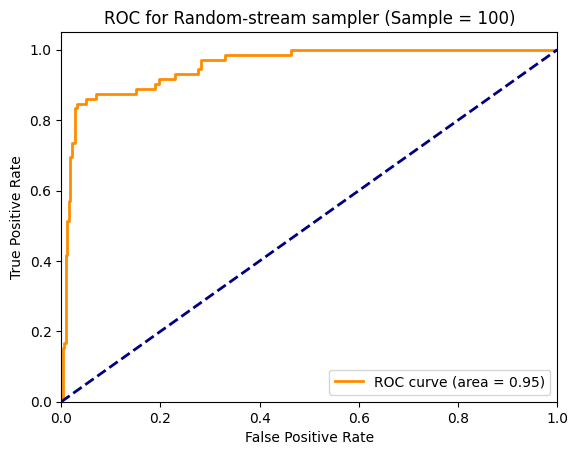

In [128]:
d_rnd = rnd_all_exp[0]
plot_roc(d_rnd[100][0], d_rnd[100][2], "Random-stream sampler (Sample = 100)")

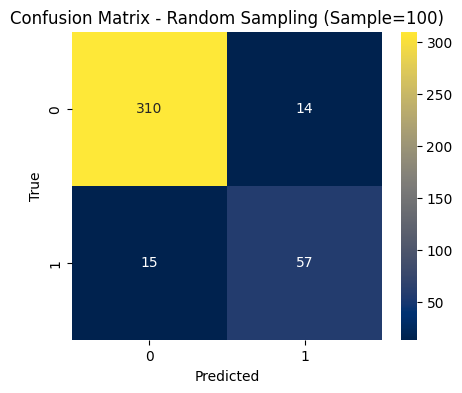

In [129]:
cms = [confusion_matrix(d_rnd[100][0], d_rnd[100][1]) for d_rnd in rnd_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(rnd_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Random Sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
def all_auc(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(roc_auc_score(exp[sample_size][0], exp[sample_size][2]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [131]:
def all_f1_score(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(f1_score(exp[sample_size][0], exp[sample_size][1]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [132]:
def all_accu_score(xrange, m_all_exp):
    iter_all_exp = []
    for exp in m_all_exp:
        # exp is a dictionary
        iter_one_exp = []
        for sample_size in xrange:
            iter_one_exp.append(balanced_accuracy_score(exp[sample_size][0], exp[sample_size][1]))
        iter_all_exp.append(iter_one_exp)
    return iter_all_exp

In [133]:
f1_rnd = np.array(all_f1_score(range(24, train_data.shape[0]), rnd_all_exp))
avg_f1_rnd = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_f1_rnd.shape)

(192,)


In [134]:
acc_rnd = np.array(all_accu_score(range(24, train_data.shape[0]), rnd_all_exp))
avg_acc_rnd = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)
print(avg_acc_rnd.shape)

(192,)


In [135]:
auc_rnd = np.array(all_auc(range(24, train_data.shape[0]), rnd_all_exp))
avg_auc_rnd = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)
print(avg_auc_rnd.shape)

(192,)


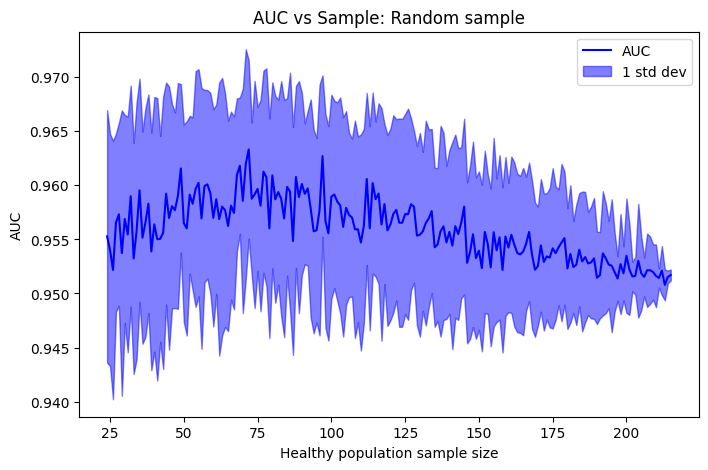

In [136]:
fill_between_plot(np.arange(24, train_data.shape[0], 1), [avg_auc_rnd], [std_auc], "AUC", "AUC vs Sample: Random sample")

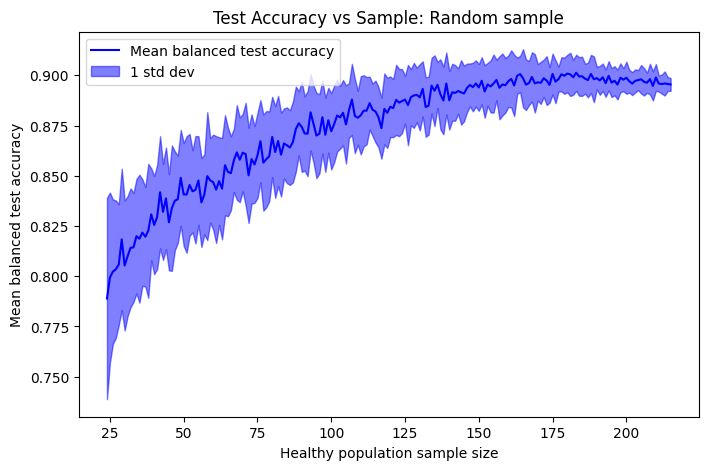

In [137]:
fill_between_plot(np.arange(24, train_data.shape[0], 1), [avg_acc_rnd], [std_acc], "Mean balanced test accuracy", "Test Accuracy vs Sample: Random sample")

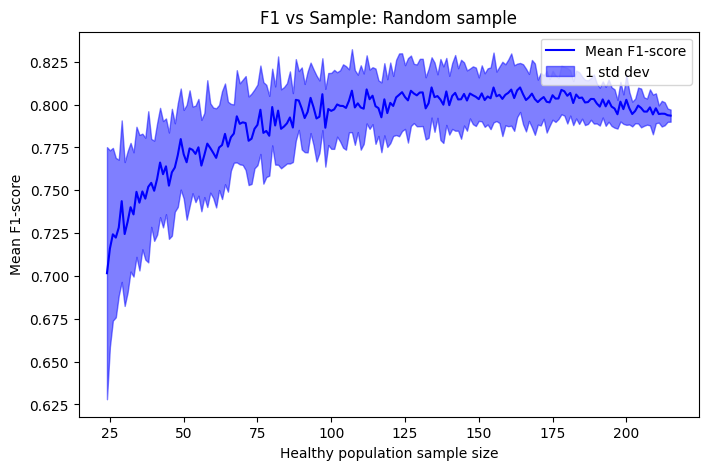

In [138]:
fill_between_plot(np.arange(24, train_data.shape[0], 1), [avg_f1_rnd], [std_f1], "Mean F1-score", "F1 vs Sample: Random sample")

In [140]:
import pickle

with open('rnd_all_exp_rbf.pkl', 'wb') as file:
    pickle.dump(rnd_all_exp, file)

### Method 1: Entropy-sampling 

In [60]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

In [61]:
# Suppress specific warnings globally
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [62]:
# since River does not support active learning with one class classifier, we define here a wrapper that converts a OCC-SVM into a binary classifier 
# Note: 0 is outlier, 1 is inlier

class OneClassSVMWrapper:
    def __init__(self, **params):
        self.model = OneClassSVM(**params)
        self.data = []
        self.is_fitted = False

    def learn_one(self, x, y=None):
        # Add the new instance to the data pool
        features = list(x.values())
        self.data.append(features)
        occ_svm =  GridSearchCV(OneClassSVM(), param_grid_occ_svm, scoring='accuracy', cv=5) if (len(self.data) > 0 and int(len(self.data)%20) == 0) else self.model
        self.model = occ_svm
        self.model.fit(self.data)  # Fit the model on the accumulated data
        self.is_fitted = True

    def predict_one(self, x):
        # Returns 1 for normal, 0 for anomaly
        prediction = self.predict_proba_one(x)
        return max(prediction, key = prediction.get)
    
    def minmax_probability(self, decisions, current_decision):
        # mnmx = (current_decision - min(np.min(decisions), current_decision) ) / (max(np.max(decisions), current_decision) - np.min(decisions))
        mnmx = (current_decision - np.min(decisions) ) / (np.max(decisions) - np.min(decisions))
        return mnmx
    
    def sigmoid_probability(self, decisions, current_decision):
        mean_decision = np.mean(decisions)
        std_decision = np.std(decisions)

        # Calculate the z-score of the current decision function value
        z_score = 0
        if std_decision > 0:
            z_score = (current_decision - mean_decision) / std_decision
        else:
            z_score = 0  # Avoid division by zero

        # Convert the z-score to a pseudo-probability
        # Assuming a normal distribution, we use a sigmoid function to map z-scores to [0, 1]
        sigmoid = lambda z: 1 / (1 + np.exp(-z))
        return sigmoid(z_score)

    def predict_proba_one(self, x):
        features = list(x.values())
        #if not self.is_fitted:
        #    print("Error")
        # Use decision function as a proxy; not a true probability
        decision_function = self.model.decision_function([features])[0]
        decisions = self.model.decision_function(self.data)

        # Convert decision function to a pseudo-probability
        pseudo_probability =  self.minmax_probability(decisions, decision_function)  #self.sigmoid_probability(decisions, decision_function) 
        return {0: 1 - pseudo_probability, 1: pseudo_probability}

In [63]:
# convert test_labels the 1 (healthy) and -1 (damage) to 0 (damage) and 1 (healthy) 
test_labels_es = (test_labels + 1)/2
train_labels_es = (train_labels + 1)/2

In [64]:
def testing_model_entropy_sampling(model, test_data, save_y):
    # convert labels and data to river compatible representaitions
    y_test = test_labels_es
    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in test_data
    ]
    y_river_test = y_test.tolist()  
    metric = metrics.Accuracy()

    preds_y = []
    preds_proba_y = []
    true_y = []

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred_dict, _ = model.predict_proba_one(x) 
        y_pred = max(y_pred_dict, key=y_pred_dict.get)
        metric = metric.update(y_true, y_pred)

        # return these values    
        preds_y.append(y_pred)
        true_y.append(y_true)
        preds_proba_y.append(y_pred_dict[1])

    return metric, preds_y, true_y, preds_proba_y

en_all_exp = []
# across 30 seeds
for s in range(20):
    print(f"iteration {s}")
    en_dict = {}
    accuracies_train = []
    accuracies_test = []
    samples_used = []
    stop = 150000
    step = 1
    disc = 0
    factor = 1.12
    while disc < stop:
        save_y = False
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in train_data
        ]
        y_river = train_labels_es.tolist() 

        metric = metrics.Accuracy()
        base_model = OneClassSVMWrapper(nu = 0.1) 
        # if nu is set too low, then we have less training error for the OCC but then each new point we add will automatically be the one with minimum distance 
        # as a result if we set nu below 0.5 then we risk not sampling any point
        model = active.EntropySampler(base_model, discount_factor=disc, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for i in range(len(X_river)):
            # for the first 10 instances we only learn without updating any metric
            x = X_river[i]
            y_true = y_river[i]
            
            if i < 5:
                n_samples_used += 1
                model = model.learn_one(x, y_true)
                continue

            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)
        
        disc =int(disc + step)
        step *= factor
        
        # samples_used needs to be strictly decreasing sequence 
        if n_samples_used < 20  or (len(samples_used) > 0 and (samples_used[-1] <= n_samples_used)):
            continue

        acc_train = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_train.append(acc_train)
        samples_used.append(n_samples_used)

        metric, preds_y, true_y, preds_proba_y = testing_model_entropy_sampling(model, test_data, save_y)
        # save them to the dictionary and push it 
        en_dict[n_samples_used] = [true_y, preds_y, preds_proba_y]
        
    en_all_exp.append(en_dict)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


In [65]:
lb = min([min(list(en_all_exp[i].keys())) for i in range(len(en_all_exp))])
ub = max([max(list(en_all_exp[i].keys())) for i in range(len(en_all_exp))])
xrange = np.arange(lb, ub)
auc_arr = []
acc_arr = []
f1_arr  = []
for exp in en_all_exp:
    skeys = sorted(exp.keys(), key=lambda x: int(x))
    xvals = []
    aucvals = []
    accvals = []
    f1vals  = []
    for key in skeys:
        xvals.append(key)
        truey = exp[key][0]
        predy = exp[key][1]
        proby = exp[key][2]

        # metrics
        rauc = roc_auc_score(truey, proby)
        acc = balanced_accuracy_score(truey, predy)
        f1 = f1_score(truey, predy)

        # append
        aucvals.append(rauc)
        accvals.append(acc)
        f1vals.append(f1)
    
    # interpolate and then append to the outer arrays
    f1vals = np.interp(np.arange(lb, ub), xvals, f1vals)
    accvals = np.interp(np.arange(lb, ub), xvals, accvals)
    aucvals = np.interp(np.arange(lb, ub), xvals, aucvals)

    auc_arr.append(aucvals)
    acc_arr.append(accvals)
    f1_arr.append(f1vals)

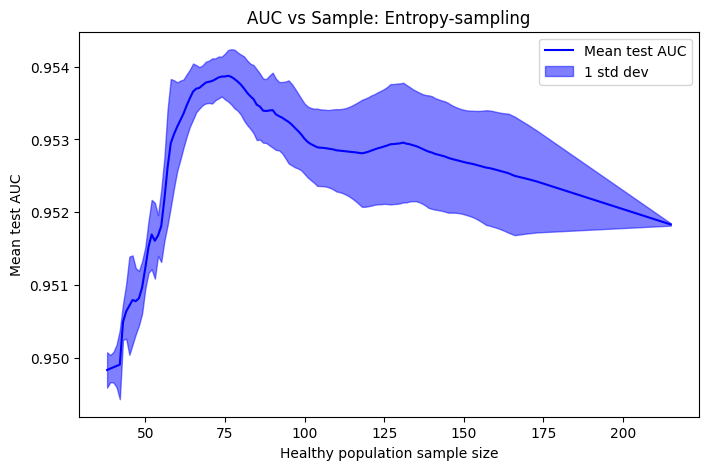

In [66]:
fill_between_plot_diffx(np.arange(lb, ub), [np.mean(np.array(auc_arr), axis = 0)], [np.std(np.array(auc_arr), axis = 0)], "Mean test AUC", "AUC vs Sample: Entropy-sampling")

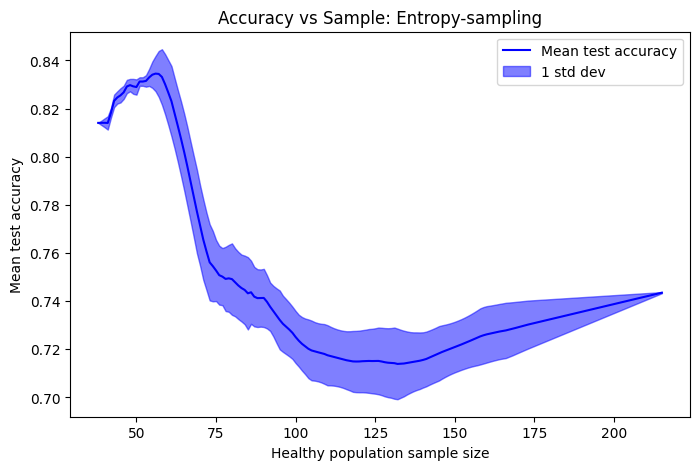

In [67]:
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(acc_arr), axis = 0)], [np.std(np.array(acc_arr), axis = 0)], "Mean test accuracy", "Accuracy vs Sample: Entropy-sampling")

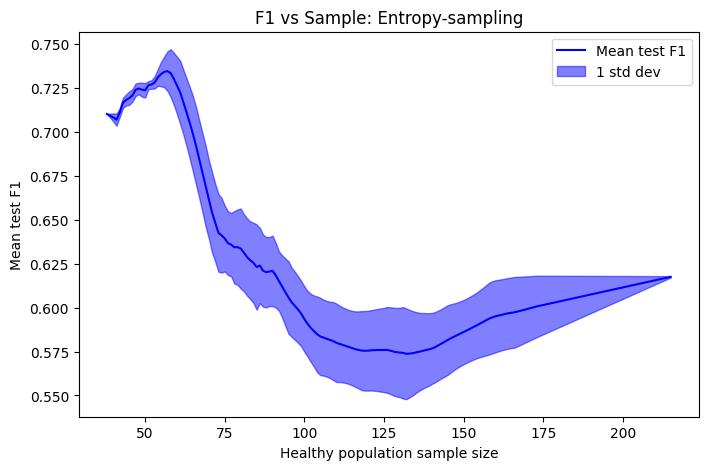

In [68]:
fill_between_plot(np.arange(lb, ub), [np.mean(np.array(f1_arr), axis = 0)], [np.std(np.array(f1_arr), axis = 0)], "Mean test F1", "F1 vs Sample: Entropy-sampling")

dict_keys([216, 158, 136, 120, 101, 95, 92, 85, 78, 72, 69, 55, 52, 50, 49, 45, 43, 38])


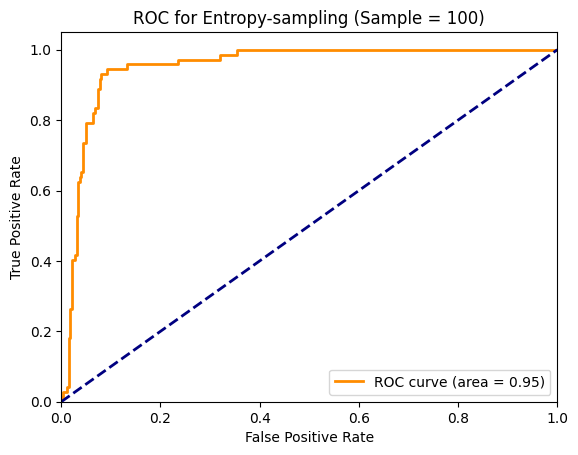

In [141]:
d_rnd = en_all_exp[1]
print(d_rnd.keys())
plot_roc(d_rnd[101][0], d_rnd[101][2], "Entropy-sampling (Sample = 100)")

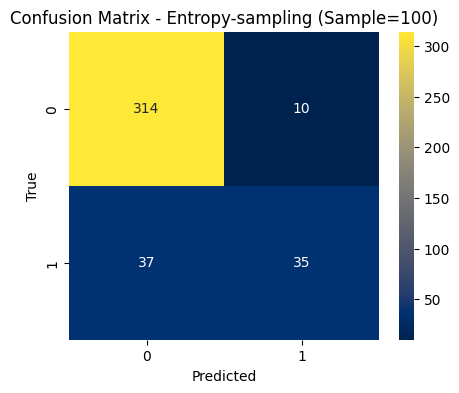

In [142]:
def find_closest_key(my_dict, target_key):
    closest_key = None
    min_diff = float('inf')

    for key in my_dict.keys():
        diff = abs(int(key) - target_key)
        if diff < min_diff:
            min_diff = diff
            closest_key = key

    return my_dict[closest_key]

cms = [confusion_matrix(find_closest_key(d_rnd, 100)[0], find_closest_key(d_rnd, 100)[1]) for d_rnd in en_all_exp]
sum_conf_matrix = np.sum(cms, axis=0)
mean_conf_matrix = sum_conf_matrix / len(en_all_exp)
plt.figure(figsize=(5, 4))
sns.heatmap(np.around(mean_conf_matrix).astype(int), annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Entropy-sampling (Sample=100)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [74]:
import json
with open('en_all_exp4.json', 'w') as file:
    json.dump(en_all_exp, file)

#### Plot the entropy (~anomaly score)

In [143]:
def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

In [148]:
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in train_data
]
y_river = train_labels_es.tolist() 

metric = metrics.Accuracy()
base_model = OneClassSVMWrapper(nu = 0.01)
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]

    if i < 5:
        n_samples_used += 1
        model = model.learn_one(x, y_true)
        continue

    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

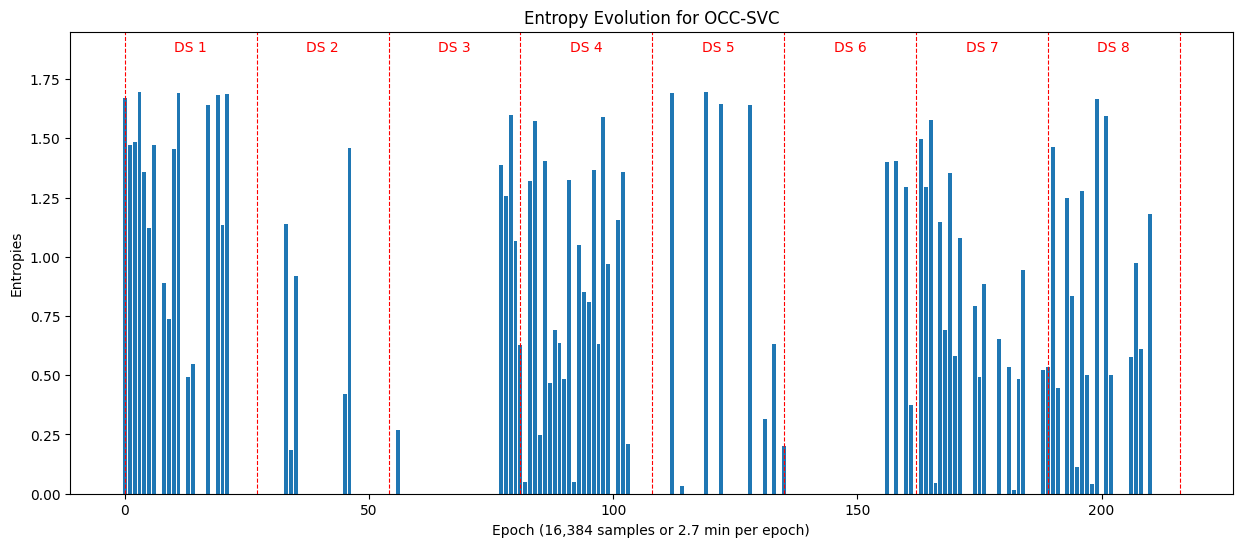

In [149]:
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.reset_orig()
plt.figure(figsize=(15, 6))
nbr_epochs = train_data.shape[0]

entropies_reshaped = np.array(entropies).reshape(-1, 1)
for i in range(0, nbr_epochs+1, 27):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

sc = StandardScaler()
obs = np.arange(len(entropies))
std_entropies = sc.fit_transform(entropies_reshaped).flatten()
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Entropies')
plt.title(f'Entropy Evolution for OCC-SVC')
text_pos = [i+13.5 for i in range(0, nbr_epochs, 27)]
for idx, pos in enumerate(text_pos):
    plt.text(pos, max(std_entropies)*1.1, f'DS {idx+1}', ha='center', color='red')

plt.show()

### Method 2: Changepoint detection using Gaussian scoring

In [88]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.ion()  # Turn on interactive mode

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

class IncrementalGaussianFitter:
    def __init__(self):
        self.mean = np.array([0.0, 0.0, 0.0])
        self.covariance = np.eye(3)
        self.count = 0

    def update(self, new_point):
        self.count += 1
        old_mean = self.mean.copy()
        self.mean += (new_point - self.mean) / self.count
        self.covariance = ((self.count - 1) * self.covariance + 
                           np.outer(new_point - old_mean, new_point - self.mean)) / self.count

    def get_mean(self):
        return self.mean

    def get_covariance(self):
        return self.covariance

# Function to generate random 3D points
def generate_random_3d_points(n_points, center=[0, 0, 0], scale=1):
    return np.random.randn(n_points, 3) * scale + center

# Function to plot 3D points and Gaussian ellipsoid
def plot_3d_gaussian(mean, covariance, points, points_test):
    mean = np.mean(points, axis=0)
    covariance = np.cov(points, rowvar=False)
    print(covariance.shape)

    # Eigen decomposition for principal components
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    print(eigenvectors.shape)
    eigenvectors = eigenvectors/ np.linalg.norm(eigenvectors, axis=0)

    # Create a grid for the ellipsoid
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = 2*np.sqrt(eigenvalues[0])*np.outer(np.cos(u), np.sin(v))
    y = 2*np.sqrt(eigenvalues[1])*np.outer(np.sin(u), np.sin(v))
    z = 2*np.sqrt(eigenvalues[2])*np.outer(np.ones(np.size(u)), np.cos(v))

    # Scale each point by the square root of the corresponding eigenvalue (standard deviation)
    for i in range(len(x)):
        for j in range(len(x[0])):
            [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], eigenvectors) + mean

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the original points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', marker='o')
    ax.scatter(points_test[:, 0], points_test[:, 1], points_test[:, 2], color='red', marker='o')

    # Plot the ellipsoid
    ax.plot_surface(x, y, z, color='orange', alpha=0.3)

    # Plot principal axes as line segments
    for i in range(3):
        axis_start = np.zeros(3)
        axis_end =  eigenvectors[:, i] * np.sqrt(eigenvalues[i]) * 2  # Scale factor for visibility
        ax.plot([axis_start[0], axis_end[0]], [axis_start[1], axis_end[1]], color='green', linewidth=2)

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')

    plt.show()

# Create a Gaussian fitter
fitter = IncrementalGaussianFitter()

# Generate and process points
points = train_data
for point in points:
    fitter.update(point)

# Get mean and covariance
mean = fitter.get_mean()
covariance = fitter.get_covariance()

# Plot
plot_3d_gaussian(mean, covariance, points, test_data[-324:])

(3, 3)
(3, 3)


In [82]:
np.save("3d_healthy.npy", train_data)

### Method 3: ARIMA

In [544]:
import pandas as pd
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [37]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [609]:
train_indices = healthy_idx

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [610]:
# extract the relevant file indices for training and testing separately
test_indices=  np.concatenate(test_indices)
train_indices=  np.concatenate(train_indices)

In [621]:
def plot_anomalies(title, path):
    # first window always healthy
    perc_ones = [] # percent of ones in each window
    nbr_epochs = 256
    tot_epochs = 611
    for i in range(tot_epochs):
        if i in train_indices:
            if i == 0:
                perc_ones.append(0)
                continue
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    #plt.axvspan(32*4, 32*9, color='yellow', alpha=0.08)
    plt.ylim(0, 1.15*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/8)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*8)) for i in range(0, nbr_epochs, int(nbr_epochs/8))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

256 [ 29  64 148 187]


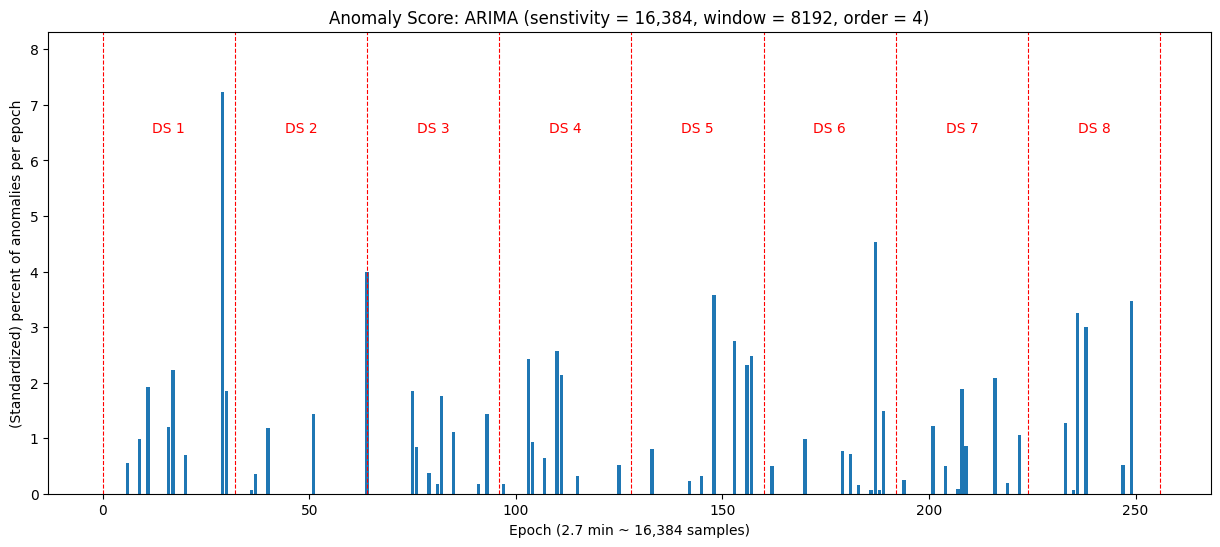

In [622]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

256 [ 22  52 172 204]


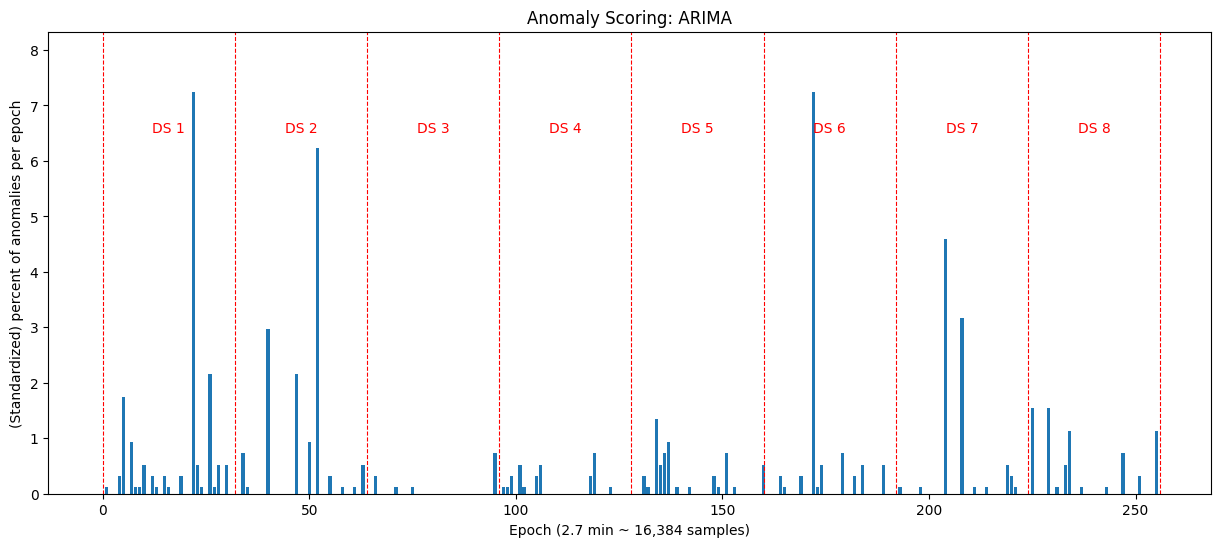

In [871]:
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

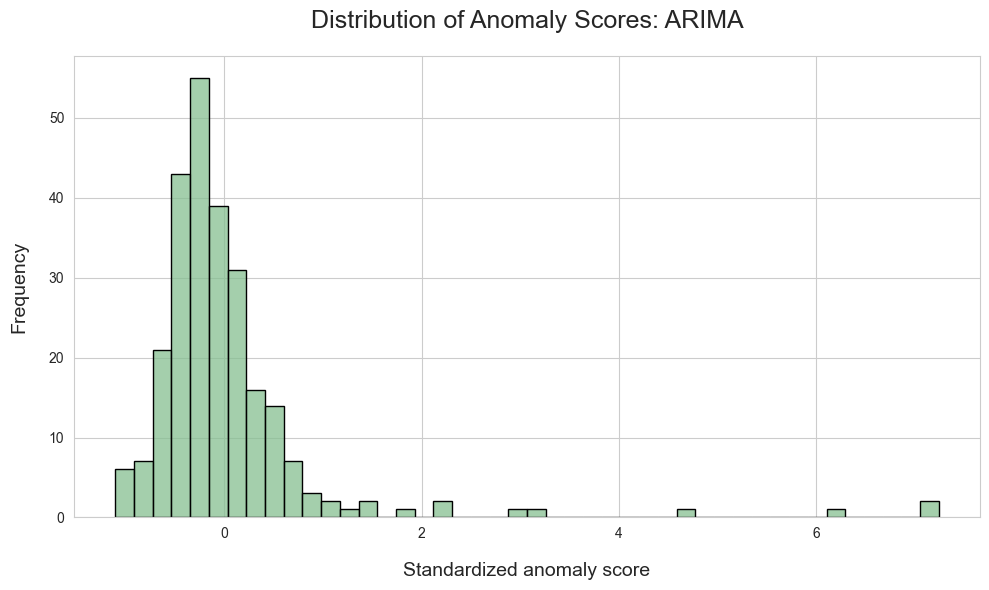

In [872]:
plot_distribution(n_res, "Distribution of Anomaly Scores: ARIMA")

In [873]:
test_acc_arima, exp_dict_ar = ad_to_al_modified(n_res, warm_st=True)

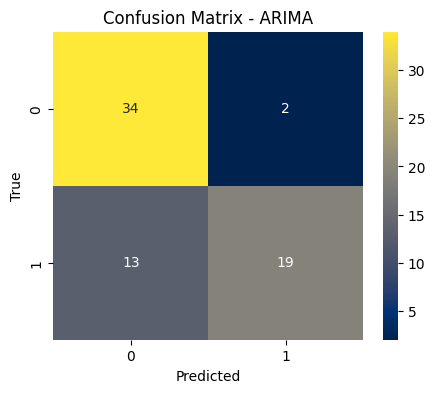

In [875]:
modes_pred = exp_dict_ar[100][1]
modes_true = exp_dict_ar[100][0]
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - ARIMA")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

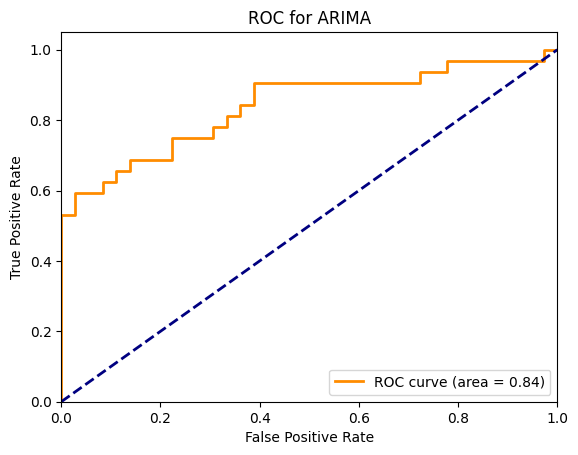

In [876]:
plot_roc(exp_dict_ar[100][0], exp_dict_ar[100][2], "ARIMA")

In [930]:
xrange = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200])
auc_rnd = np.array(all_auc(xrange, [exp_dict_ar]))
avg_auc_ar = np.mean(auc_rnd, axis = 0)
std_auc = np.std(auc_rnd, axis = 0)

acc_rnd = np.array(all_accu_score(xrange, [exp_dict_ar]))
avg_acc_ar = np.mean(acc_rnd, axis = 0)
std_acc = np.std(acc_rnd, axis = 0)

f1_rnd = np.array(all_f1_score(xrange, [exp_dict_ar]))
avg_f1_ar = np.mean(f1_rnd, axis = 0)
std_f1 = np.std(f1_rnd, axis = 0)
print(avg_auc_ar.shape)

(15,)


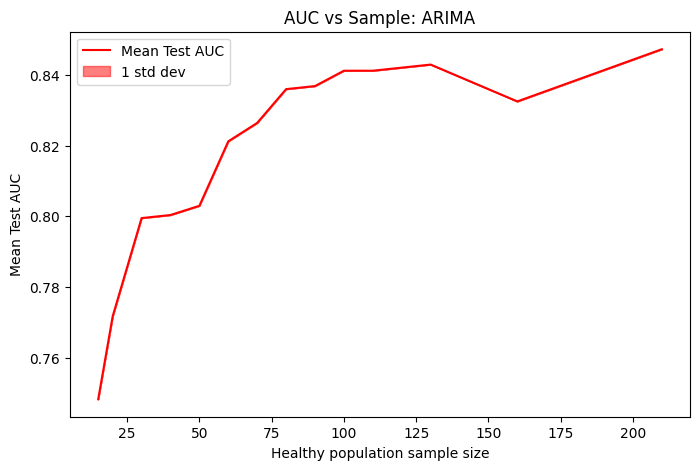

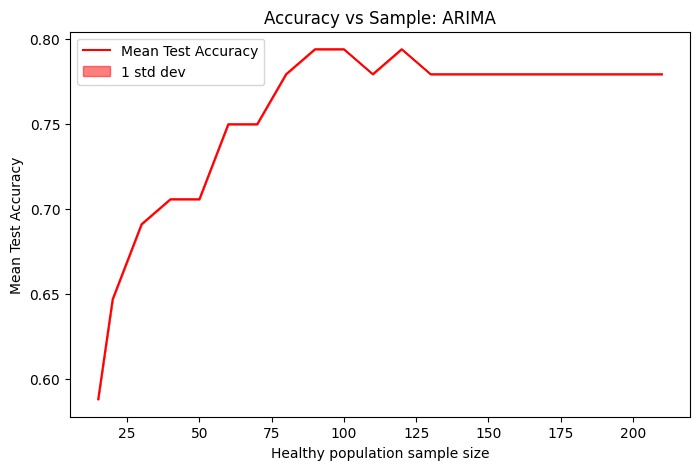

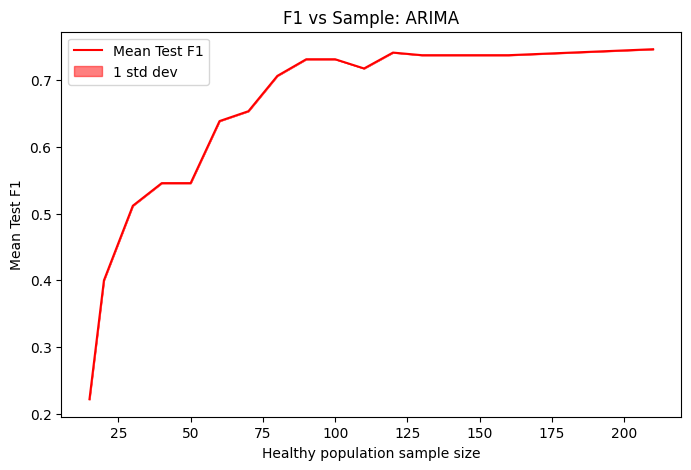

In [922]:
fill_between_plot(xrange+10, [avg_auc_ar], [std_auc], "Mean Test AUC", "AUC vs Sample: ARIMA")
fill_between_plot(xrange+10, [avg_acc_ar], [std_acc], "Mean Test Accuracy", "Accuracy vs Sample: ARIMA")
fill_between_plot(xrange+10, [avg_f1_ar], [std_f1], "Mean Test F1", "F1 vs Sample: ARIMA")

## Comparison

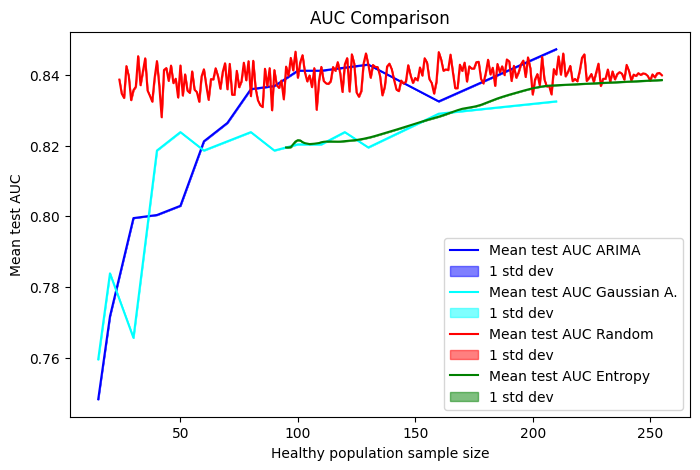

In [939]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

auc_en = np.mean(np.array(auc_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_auc_ar, avg_auc_g, avg_auc_rnd, auc_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test AUC ARIMA", "Mean test AUC Gaussian A.", "Mean test AUC Random", "Mean test AUC Entropy"], 
                        "AUC Comparison", "Mean test AUC")

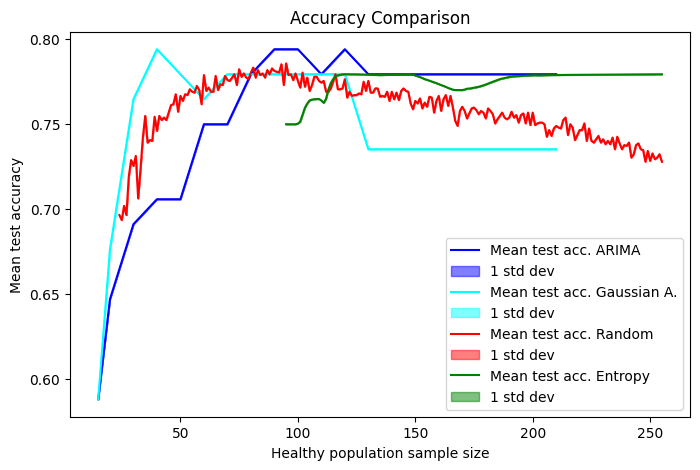

In [938]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

acc_en = np.mean(np.array(acc_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_acc_ar, avg_acc_g, avg_acc_rnd, acc_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test acc. ARIMA", "Mean test acc. Gaussian A.", "Mean test acc. Random", "Mean test acc. Entropy"], 
                        "Accuracy Comparison", "Mean test accuracy")

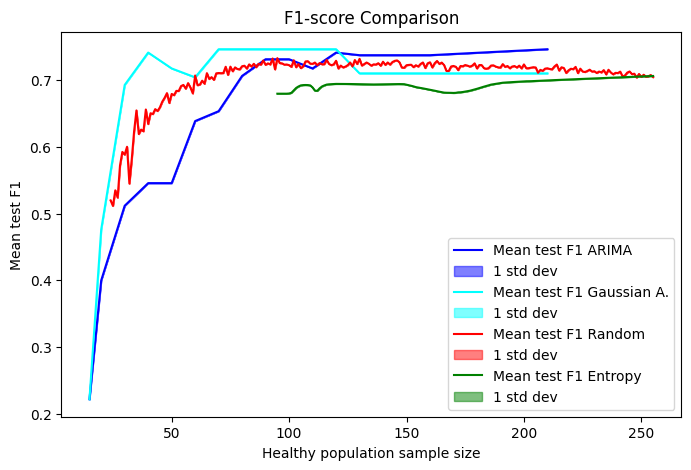

In [940]:
xrange_ad = np.array([5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200]) + 10
random_range = np.arange(24, 256, 1)
xrange_en = np.arange(95, 256)

f1_en = np.mean(np.array(f1_arr), axis = 0)
fill_between_plot_diffx([xrange_ad, xrange_ad, random_range, xrange_en], [avg_f1_ar, avg_f1_g, avg_f1_rnd, f1_en], 
                        [np.zeros(len(avg_auc_ar)), np.zeros(len(avg_auc_g)), np.zeros(len(avg_auc_rnd)), np.zeros(len(auc_en))], 
                        ["Mean test F1 ARIMA", "Mean test F1 Gaussian A.", "Mean test F1 Random", "Mean test F1 Entropy"], 
                        "F1-score Comparison", "Mean test F1")

## OCC-PCA (Studies in Big Data: Volume 82)
#### Performance Evaluation of One-Class Classifiers (OCC) for Damage Detection in Structural Health Monitoring

In [945]:
mean_vector = np.mean(train_data, axis=0)
cov_matrix = np.cov(train_data.T, rowvar=False)
mean_vector.shape, cov_matrix.shape

((35,), (256, 256))

In [943]:
mean_vector = np.mean(train_data, axis=0)
cov_matrix = np.cov(train_data, rowvar=True)
mean_vector.shape, cov_matrix.shape

((35,), (256, 256))